# Data Engineering Notebook

Explore and understand the data

# Import packages

In [2]:
# data ingestion
import urllib.request
import os
import zipfile

# data manipulation
import numpy as np
import pandas as pd

# data visualization
import seaborn as sns
from submodules.fetch_data import fetch_data
from submodules.load_data import load_data
from pandas.plotting import scatter_matrix

# data splitting
from sklearn.model_selection import train_test_split

# Overview

1. Fetch and write the data for updates using urllib, zipfile, and os for OS agnostic handling
1. Load the data as a Dataframe using Pandas
1. Explore the Dataframe with Pandas
1. Split the data into train and test sets with Scikit-Learn
1. Visualize the train data with Matplotlib and Seaborn
1. Explore correlation among features
1. Feature down selection

# Download the data
In a working environment, data is available in a relational database or data store spread
across multiple tables, documents and files. Getting authorized access to the data is a part of this step.

For this example, the data has been downloaded and extracted locally from Kaggle.
Kaggle data source: https://www.kaggle.com/maxskoryk/datasepsis

Fetch the data

In [3]:
# fetch the data using a python function, commented out b/c cannot use with Kaggle source
#fetch_data()

# Load the data
> using Pandas

Load semi-colon separated data from disk

In [4]:
# load the data using a python function
data = load_data()

# without using a python function
#csv_path = "datasets/sepsis/dataSepsis.csv"
#data = pd.read_csv(csv_path, sep=";")

# Explore the data

Based on the data, we can focus on the below attributes to indicate Sepsis variants:
1. Temp
1. HR
1. Resp
1. WBC
1. Lactate
1. Platelets
1. MAP

For SIRS

|Condition|Attribute|
|-|-|
|Body Temperature > 38.5°C or <35.0°C|Temp - Temperature (Deg C)|
|Heart rate > 90 beats per minute|HR - Heart rate (beats per minute)|
|Respiratory rate > 20 breaths per minute OR arterial CO2 tension < 32 mmHg|Resp - Respiration rate (breaths per minute)|
|White Blood Cell count > 12,000/mm^3 OR < 4,000 mm^3|WBC - Leukocyte count (count10^3/µL)|

For Severe Sepsis

|Condition|Attribute|
|-|-|
|Lactates > 2 mmol/L|Lactate - Lactic acid (mg/dL)|
|Platelet counts < 100,000/mL|Platelets - (count10^3/µL)|
> Formula to calculate mg/dl from mmol/l: mg/dl = 18 × mmol/l.
> Formula to calculate microliters (uL) to mililiter (mL) 1 μL = 0.001 ml; 1000 μL = 1 mL

For Septic Shock

|Condition|Attribute|
|-|-|
|Systemic mean blood pressure of < 60 mm Hg (< 80 mm Hg if previous hypertension)|MAP - Mean arterial pressure (mm Hg)|

# What does the raw data look like?
> using Pandas

Looking for:
- NaN (null) values, not good for training a model on
- Understand the attributes, the data values and how they align to the goal
- The types of data (numbers, categories, etc.)
- The range of data values (whole numbers, decimals, etc.)

In [5]:
# first 10 rows
data.head(10)

,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,BaseExcess,HCO3,...,WBC,Fibrinogen,Platelets,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,isSepsis
0,103.0,90.0,NaN,NaN,NaN,NaN,30.0,NaN,21.0,45.0,...,5.7,NaN,317.0,83.14,0,NaN,NaN,-0.03,17,0
1,58.0,95.0,36.11,143.0,77.0,47.0,11.0,NaN,NaN,22.0,...,11.0,NaN,158.0,75.91,0,0.0,1.0,-98.60,10,0
2,91.0,94.0,38.50,133.0,74.0,48.0,34.0,NaN,NaN,31.0,...,8.3,NaN,465.0,45.82,0,1.0,0.0,-1195.71,11,0
3,92.0,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29.0,...,12.0,NaN,298.0,52.01,1,1.0,0.0,-0.03,13,0
4,155.5,94.5,NaN,147.5,102.0,NaN,33.0,NaN,-12.0,13.0,...,9.3,NaN,26.0,64.24,1,1.0,0.0,-0.05,2,0
5,73.0,99.0,36.06,100.0,67.0,49.5,16.5,NaN,-8.0,16.0,...,11.4,NaN,357.0,87.08,1,NaN,NaN,-2.23,2,0
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,25.0,...,NaN,NaN,NaN,27.92,1,NaN,NaN,-0.03,257,1
7,82.0,100.0,35.50,112.0,79.5,63.0,14.0,NaN,0.0,23.0,...,8.7,NaN,115.0,76.71,0,0.0,1.0,-2.36,3,0
8,89.0,100.0,NaN,141.0,85.0,57.0,17.0,NaN,1.0,25.0,...,10.6,NaN,184.0,65.79,1,NaN,NaN,-0.02,35,1
9,100.0,95.0,37.28,121.0,20.0,NaN,NaN,NaN,NaN,22.0,...,7.3,NaN,127.0,81.64,1,1.0,0.0,-0.03,16,0


## Forward Action
1. need to cleanup NaN values

# What types of columns and data do we have?
> using Pandas

Looking for:
- How many total attributes we have?
- What attributes we can rule out?
- What attributes might be good for combination?
- How many Non-null values each has?
    - lower the non-null count, the least likely we can use the column
- The types of data (float, int, etc.)?
    - the columns (features) we select need to be on the same scale

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36302 entries, 0 to 36301
Data columns (total 41 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   HR                35506 non-null  float64
 1   O2Sat             34736 non-null  float64
 2   Temp              17101 non-null  float64
 3   SBP               34617 non-null  float64
 4   MAP               34846 non-null  float64
 5   DBP               27917 non-null  float64
 6   Resp              33890 non-null  float64
 7   EtCO2             1613 non-null   float64
 8   BaseExcess        7184 non-null   float64
 9   HCO3              16984 non-null  float64
 10  FiO2              6427 non-null   float64
 11  pH                9221 non-null   float64
 12  PaCO2             8430 non-null   float64
 13  SaO2              4335 non-null   float64
 14  AST               10391 non-null  float64
 15  BUN               32526 non-null  float64
 16  Alkalinephos      10269 non-null  float6

## Forward Action
1. separate numeric from categorical data
1. explore the null entries in the attributes

# What columns have low entries vs high entries?
> 20% used below is not an academic calculation

Looking for:
- Columns with fewer than 7k entries (under-repesented <20%)
- Columns with more than 7k entries (representative >20%)
- Later in the notebook, is there correlation between under-repesented attributes and representative attributes

In [7]:
data.count(axis=0).sort_values(ascending=True)

Bilirubin_direct     1132
EtCO2                1613
Fibrinogen           2141
TroponinI            3746
Lactate              4134
SaO2                 4335
FiO2                 6427
BaseExcess           7184
PaCO2                8430
pH                   9221
Alkalinephos        10269
Bilirubin_total     10313
AST                 10391
PTT                 13875
HCO3                16984
Temp                17101
Chloride            17365
Phosphate           21768
Unit2               22221
Unit1               22221
Magnesium           27671
DBP                 27917
Calcium             28623
WBC                 31460
Platelets           31469
Hgb                 31816
Hct                 32180
Creatinine          32260
BUN                 32526
Potassium           32709
Glucose             33257
Resp                33890
SBP                 34617
O2Sat               34736
MAP                 34846
HR                  35506
Age                 36302
ICULOS              36302
HospAdmTime 

## Forward Action
1. look for correlation and drop
    1. Bilirubin_direct
    1. EtCO2
    1. Fibrinogen
    1. TroponinI
    1. Lactate
    1. SaO2
    1. FiO2
    1. BaseExcess
    1. PaCO2
    1. pH

# Calculus measures on the data
> using Pandas

- Null values are ignored in the summary
- Highest number of entries for a column ~ 36k
    - likely to consider if it helps indicate the prediction
- Lowest number of entries for a column ~1k
    - likely to drop because there are too many missing entries to train a model on
- Average (mean), minimum (min), maximum (max) are self-explanatory
- Standard deviation (std) how dispersed the values are
    - normal (Gaussian) distribution follows 68-95-99.7 rule
        - 68% of values are within 1 std
        - 95% of values are within 2 std
        - 99.7% of values are within 3 std
- 1st (25%), median (50%), 3rd (75%) quartiles or percentiles, for example:
    - 25% of the patients had a temp lower than 36.3°C
    - 75% of the patients had a resp higher than 20.5 breaths per minute
- min/max
    - if min == 0 and max == 1, likely discrete categorical data
    - identify ranges for possible feature scaling

In [8]:
data.describe(include="all").T

,count,mean,std,min,25%,50%,75%,max
HR,35506.0,83.547246,17.486670,26.00,71.00,82.000,94.0000,184.00
O2Sat,34736.0,97.444337,2.827282,27.00,96.00,98.000,100.0000,100.00
Temp,17101.0,36.824187,0.855630,26.67,36.30,36.800,37.3900,41.80
SBP,34617.0,122.625064,23.092558,32.00,106.00,120.000,137.0000,281.00
MAP,34846.0,82.263649,16.876642,20.00,71.00,80.000,91.3300,291.00
DBP,27917.0,63.793506,14.130816,22.00,54.00,62.000,72.0000,281.00
Resp,33890.0,18.041841,5.020912,1.00,15.00,18.000,20.5000,59.00
EtCO2,1613.0,32.402046,7.947214,10.00,28.00,33.000,37.5000,97.00
BaseExcess,7184.0,-0.306508,4.151943,-29.00,-2.00,0.000,2.0000,36.00
HCO3,16984.0,24.255841,4.150083,5.00,22.00,24.000,26.0000,55.00


## Forward Action

1. BaseExcess has a negative entry that could cause errors
1. Of the known indicators:
    1. Temp - missing ~50% data
    1. HR - may need scaling
    1. Resp - may need scaling
    1. WBC - may need scaling
    1. Lactate - look for correlation, drop
    1. Platelets - may need scaling
    1. MAP - may need scaling

# Are Sepsis patient entries representative of the real world?
> using Pandas

Looking for:
- How many patients had Sepsis?

In [9]:
data["isSepsis"].value_counts(normalize=True).to_frame()

,isSepsis
0,0.927084
1,0.072916


The training data is representative of real world Sepsis identification in patience.

# Create a Test Dataset
> uses scikit-learn

Performing this early minimizes generalization and bias you may inadvertently apply to your system.
Simply put, a test set of data involves: picking ~20% of the instances randomly and setting them aside.

Some considerations for sampling methods that generate the test set:
1. you don't want your model to see the entire dataset
1. you want to be able to fetch new data for training
1. you want to maintain the same percentage of training data against the entire dataset
1. you want a representative training dataset (~7% septic positive)

https://realpython.com/train-test-split-python-data/

In [10]:
# drop the isSepsis label from the X_ dataset and store in the y_ dataset
# split the whole dataset 10% test and 90% training
# random state fixes the randomization so you get the same results each time
# Shuffle before the data is split, this is important specifically if any data is order (e.x. by gender)
# stratified splitting keeps the proportion of y values trhough the train and test sets and it uses the same calculation y does
# the sequence of the X_ than y_ is critical in scoring correctly

X_train, X_test, y_train, y_test = \
    train_test_split(data.drop("isSepsis", axis=1),
                     data["isSepsis"], test_size=0.1,
                     random_state=42, stratify=data["isSepsis"])

print("Training data: ", X_train.shape)
print("Training labels: ", y_train.shape)

print("Testing data: ", X_test.shape)
print("Testing labels: ", y_test.shape)

Training data:  (32671, 40)
Training labels:  (32671,)
Testing data:  (3631, 40)
Testing labels:  (3631,)


# What does the data look like if we plotted each attributes values?
> uses matplotlib

Things to pay attention to:

- Indicators:
    - HR
    - Temp
    - Resp
    - Lactate
    - MAP
    - Platelets
    - WBC
- Categorical data:
    - Gender
    - Unit1 and 2

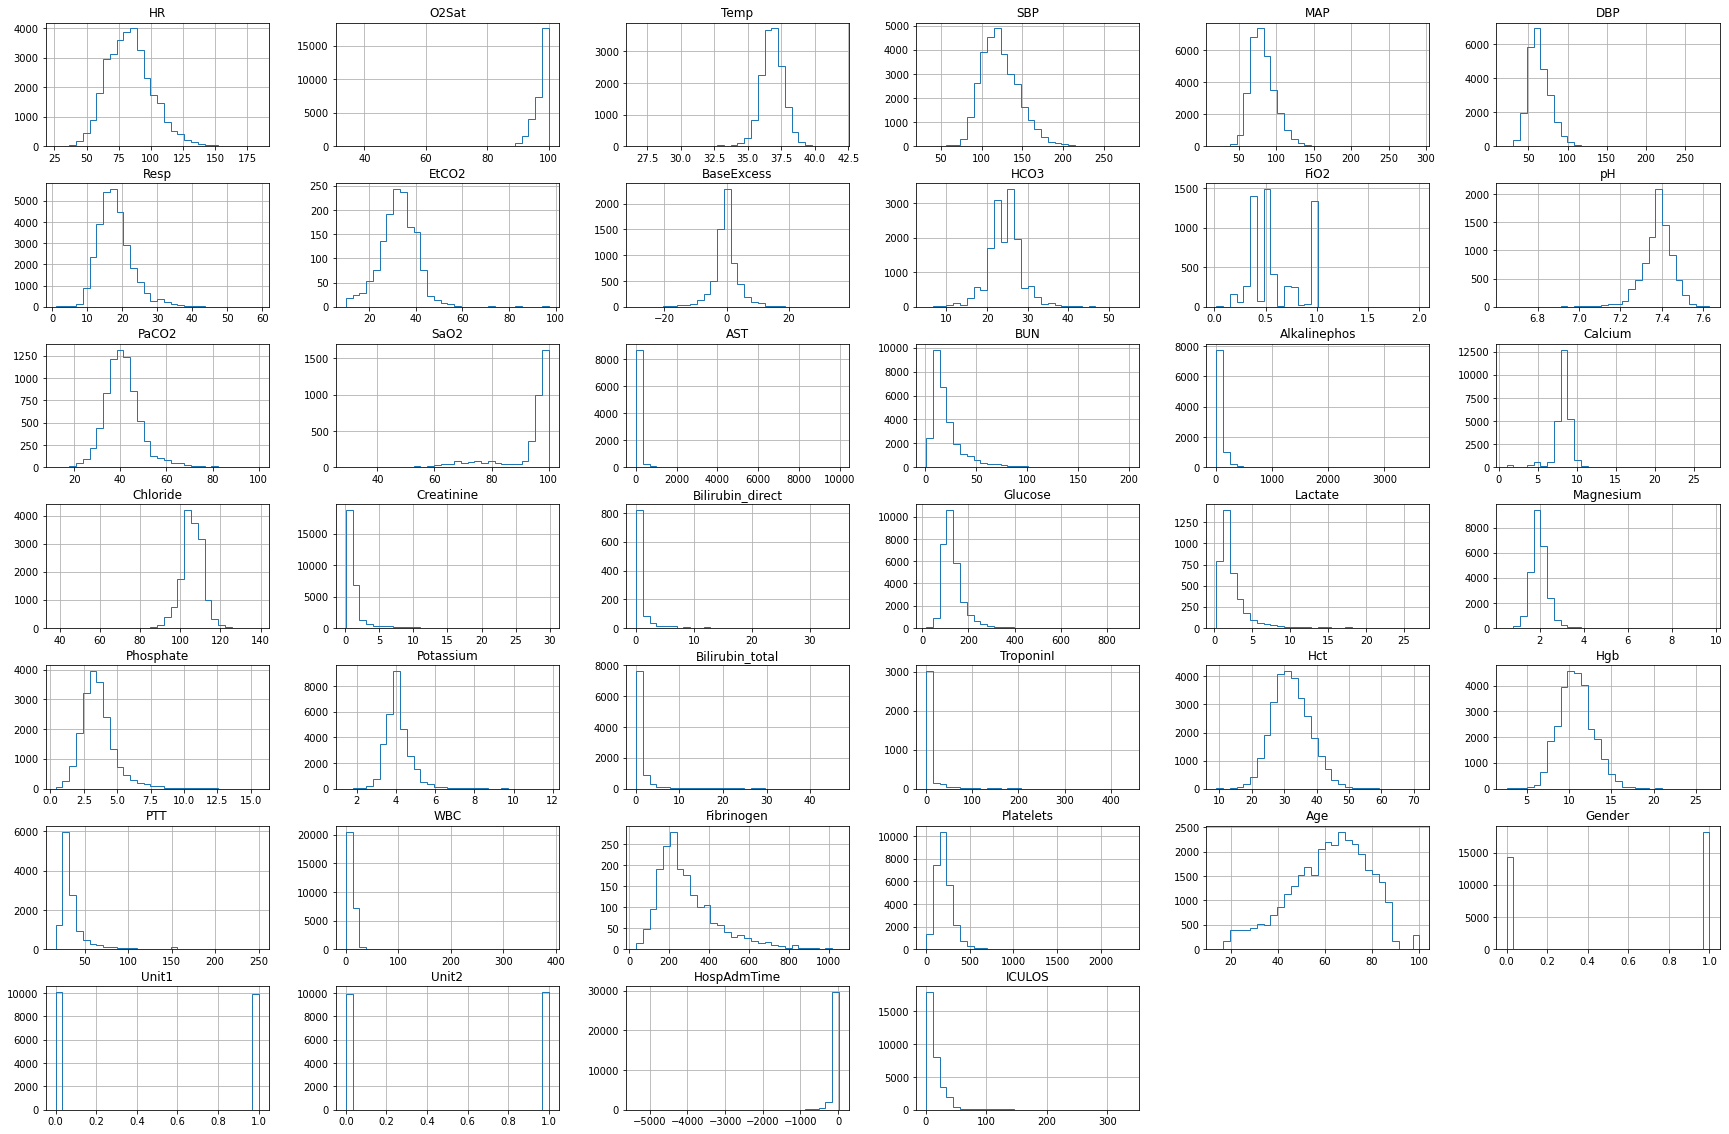

In [11]:
# % denotes a jupyter magic command, telling matplotlib to use Jupyters backend
%matplotlib inline
import matplotlib.pyplot as plt
X_train.hist(bins=30, figsize=(30,20), histtype='step')
plt.show()

Separate the data categories: vitals, labs, and demographics

In [12]:
vitals = ["HR", # Heart Rate normal adult 60 - 100 beats per minute (bpm)
          'O2Sat', # Oxygen saturation normal adult 97% - 100% (%)
          'Temp', # Temperature normal 97.8°F/36.5°C - 99°F/37.2°C (°C)
          'SBP', # Systolic Blood Pressure normal < 120 mmHg (mm Hg) (indicates how much pressure your blood is exerting against your artery walls when the heart beats.)
          'DBP', # beclomethasone dipropionate normal < 80 mmHg (mm Hg) (indicates how much pressure your blood is exerting against your artery walls while the heart is resting between beats.)
          'MAP', # Mean Arterial Pressure (mm Hg)
          'Resp', # Respiration rate  12<normal<20 breaths / minute (bpm)
          "EtCO2" # End-tidal CO2 maximum concentration of CO2 at exhalation normal 35 - 45 mmHg (mm Hg)
          ]

labs = ['BaseExcess', # strong acid to restore pH (mmoI/L)
        'Magnesium', # symptoms such as weakness, irritability, cardiac arrhythmia, nausea, and/or diarrhea (mmoI/L)
        'Glucose', # blood sugar test (indicates diagnose diabetes, pre-diabetes and gestational diabetes) (mg/dL)
        'Alkalinephos', # Alkaline phosphatase (indicates enzyme activity) (IU/L)
        'pH', # 0:14 = acidic = lower pH; alkaline = higher
        'Chloride', # an electrolyte to balance fluid in cells normal 96-103 ml (indicates blood pressure/pH) (mmoI/L)
        'Lactate', # high levels indicate lack of oxygen (hypoxia) or other conditions (indicates sepsis) (mg/dL)
        # Respiratory
        'HCO3', # Bicarbonate, carbon dioxide in blood (indicates metabolism / resp) (mmoI/L)
        'FiO2', # % of concentration of oxygen inhaled (indicates resp) (%)
        'PaCO2', # partial pressure of carbon dioxide measured in blood (indicates resp) (mm Hg)
        'SaO2', # normal 95-100% oxygen saturation bound to hemoglobin (indicates resp) (%)
        # liver
        'AST', # aspartate aminotransferase (indicates liver) (IU/L)
        'Bilirubin_direct', # conjugated water soluble (indicates liver) (mg/dL)
        'Bilirubin_total', # normal 0.1:1.2 mg/dL (indicates liver) (mg/dL)
        # kidneys
        'BUN', # blood urea nitrogen, nitrogen in the blood (indicates kidneys) (mg/dL)
        'Creatinine', # metabolic panel (indicates kidneys) (mg/dL)
        'Calcium', # indicates range of conditions bones, heart, nerves, kidneys, and teeth (mg/dL)
        'Phosphate', # related to calcium (indicates kidney or diabetes)  (mg/dL)
        'Potassium', # electrolyte or metabolism (affected by blood pressure, kidneys, etc.)  (mmoI/L)
        # Heart
        'TroponinI', # cardiac specific Trenonin I and T (indicates injury to heart muscle)
        # Blood
        'Hct', # Hematocrit (indicates portion of blood from Red Blood Cell count) (%)
        'Hgb', # Hemoglobin apart of Complete Blood Count (CBC) (indicates blood cell count) (g/dL)
        'WBC', # White Blood Cell Count (indicates infection, inflammation or disease) (count10^3/µL)
        'PTT', # Partial Thromboplastin Time (indicates bleeding or blood clot) (seconds)
        'Fibrinogen', # coagulation factor I (indicates bleeding or blood clot or cardiovascular disease) (mg/dL)
        'Platelets' # indicates bleeding disorder, a bone marrow disease, or other underlying condition ((count10^3/µL))
        ]

demo = ['Age', # Years (100 for patients 90 or above)
        'Gender', # Female = 0, Male = 1
        'HospAdmTime', # Hours between hospital admit and ICU admit
        'ICULOS' # ICU length of stay in hours (hours since ICU admit)
        ]

Set the theme of your charts for consistency and audience

In [13]:
# set the plot style
sns.set_theme(context="notebook", style="ticks", palette="colorblind")
#sns.set_theme(context="poster", style="dark", palette="Set2")
#sns.set_theme(context="talk", style="whitegrid", palette="tab10")

## What does the training look like for each grouping of values for vitals, labs, and demographics?
> uses seaborn

### Vital signs
Pay attention to clean splits in the charts for isSepsis

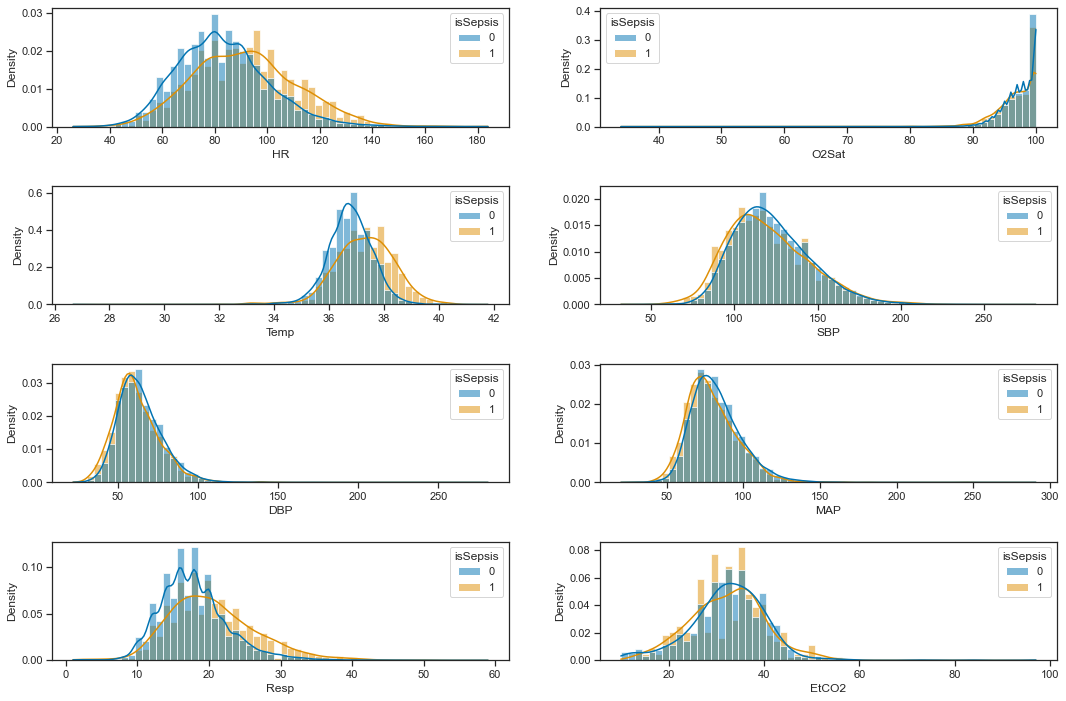

In [14]:
plt.figure(figsize=(18,12))
plt.subplots_adjust(hspace = .5)
for i, column in enumerate(vitals, 1):
    plt.subplot(4,2,i)
    # stat = Aggregate statistic to compute in each bin density normalizes counts so that the area of the histogram is 1
    # common_norm = False = normalize each histogram independently
    # kde = If True, compute a kernel density estimate to smooth the distribution and show on the plot as (one or more) line(s)
    sns.histplot(data=X_train, x=column, hue=y_train, stat="density", common_norm=False, bins=60, kde=True)

#### Forward Action
1. HR, Temp, MAP, Resp all have clear separation between Septic and non-Septic patients
1. SBP and DBP are used to calculate MAP, could drop
1. no clear pattern in O2Sat and EtCO2

### Laboratory values
Pay attention to clean splits in the charts for isSepsis, remember under-representative data and look for outliers

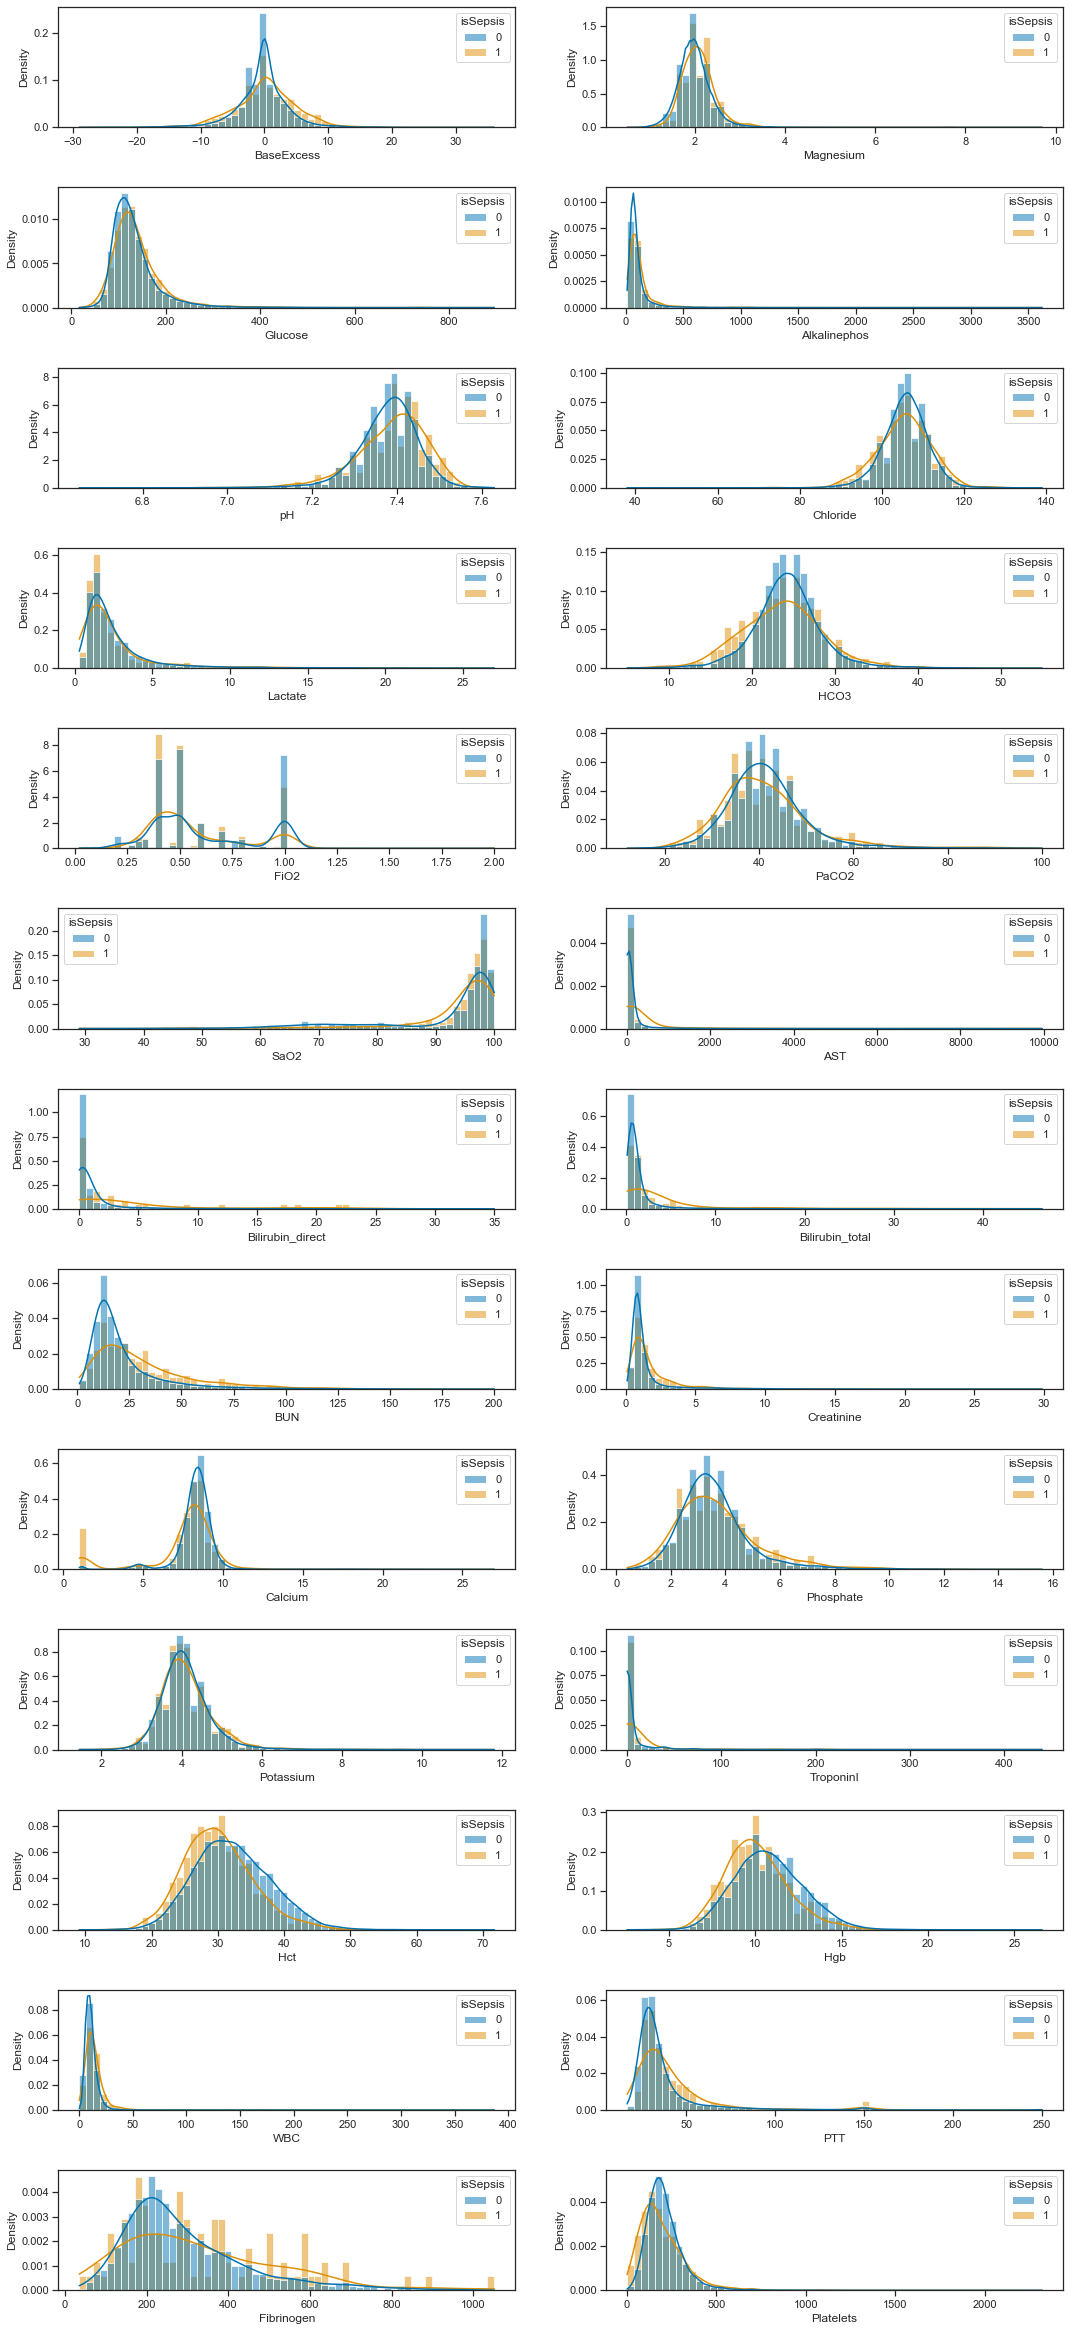

In [15]:
plt.figure(figsize=(18,42))
plt.subplots_adjust(hspace = .5)
for i, column in enumerate(labs, 1):
    plt.subplot(13,2,i)
    sns.histplot(data=X_train, x=column, hue=y_train, stat="density", bins=60, common_norm=False, kde=True)

#### Forward Action
1. BaseExcess, Magnesium, Glucose, Alkalinephos, FiO2, AST, Potassium, TroponinI no clear pattern
1. pH, Chloride, Lactate, HCO3, PaCO2, SaO2, BUN, Creatine, Phosphate, WBC, PTT, Fibrinogen have interesting evelations
1. Bilirubin_direct (underrepresented) and Bilirubin_total look similar
1. Calcium has a strong outlier in Septic patients
1. Hct and Hgb have clearn separation
1. Platelets have a clear low count for Septic patients

### Demographic data
Pay attention to clean splits in the charts for isSepsis:
- duration in Sepsis patient ICULOS
Consider dropping due to lack of Sepsis indication:
- Age
- Gender
- HospAdmTime

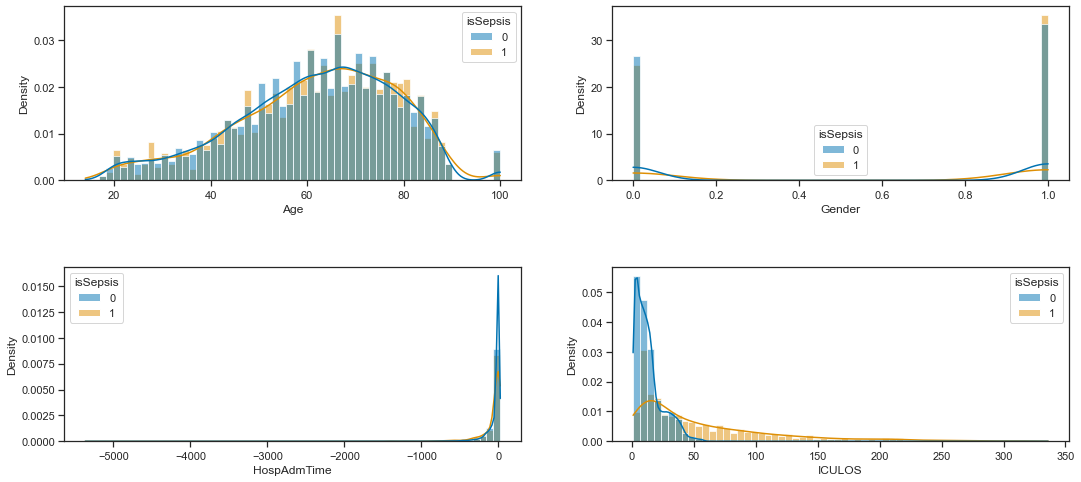

In [16]:
plt.figure(figsize=(18,8))
plt.subplots_adjust(hspace = .5)
for i, column in enumerate(demo, 1):
    plt.subplot(2,2,i)
    sns.histplot(data=X_train, x=column, hue=y_train, stat="density", bins=60, common_norm=False, kde=True)

#### Forward Action
1. None of these are biological markers and don't really indicate Sepsis

## Is there correlation between numeric values?
> uses matplotlib

Vital signs
- SBP, DBP, MAP
Lab values
- BaseExcess, pH, Chloride, Lactate, HCO3, PaCO2,
- Bilirubin_direct, Bilirubin_total
- Hct, Hgb

<AxesSubplot:>

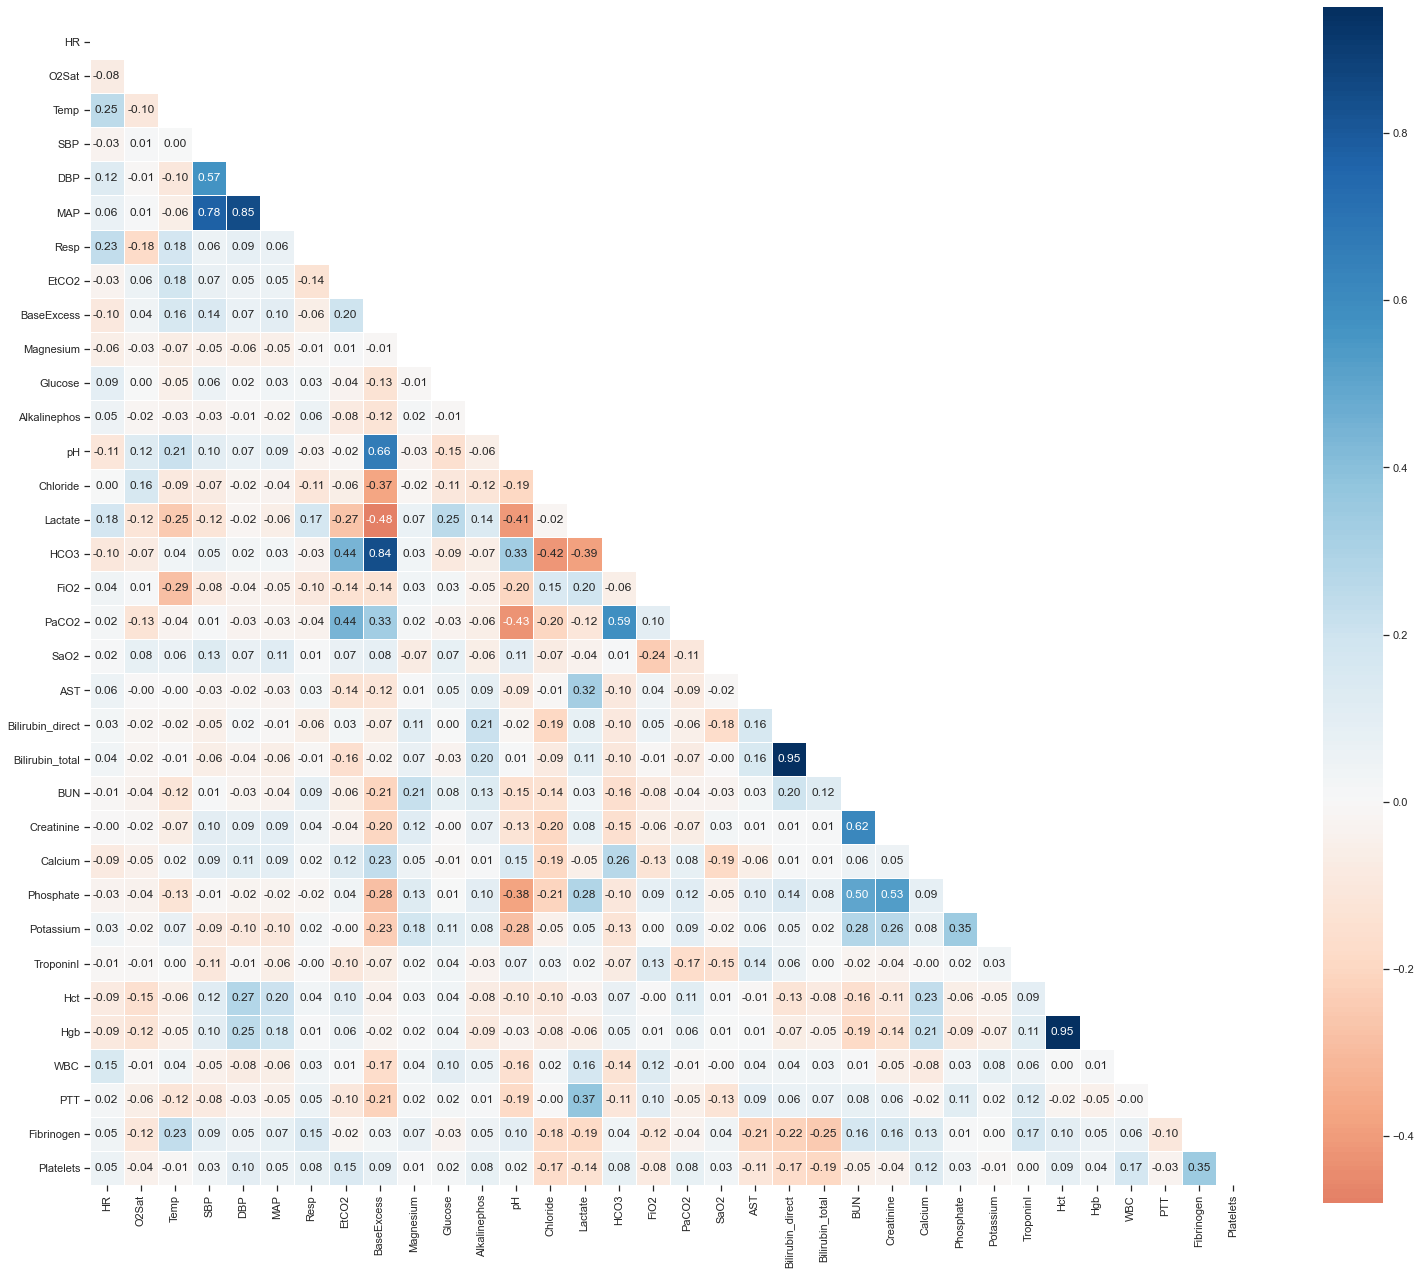

In [20]:
corr_features = [
               # vitals
               "HR", # Heart Rate normal adult 60 - 100 beats per minute (bpm)
               "O2Sat", # Oxygen saturation normal adult 97% - 100% (%)
               "Temp", # Temperature normal 97.8°F/36.5°C - 99°F/37.2°C (°C)
               "SBP", # Systolic Blood Pressure normal < 120 mmHg (mm Hg)
               "DBP", # beclomethasone dipropionate normal < 80 mmHg (mm Hg)
               "MAP", # Mean Arterial Pressure (mm Hg)
               "Resp", # Respiration rate  12<normal<20 breaths / minute (bpm)
               "EtCO2", # End-tidal CO2 maximum concentration of CO2 at exhalation normal 35 - 45 mmHg (mm Hg) = REMOVED missing too much data
                # labs
              'BaseExcess', # strong acid to restore pH (mmoI/L)
              'Magnesium', # symptoms such as weakness, irritability, cardiac arrhythmia, nausea, and/or diarrhea (mmoI/L)
              'Glucose', # blood sugar test (indicates diagnose diabetes, pre-diabetes and gestational diabetes) (mg/dL)
              'Alkalinephos', # Alkaline phosphatase (indicates enzyme activity) (IU/L)
              'pH', # 0:14 = acidic = lower pH; alkaline = higher
              'Chloride', # an electrolyte to balance fluid in cells normal 96-103 ml (indicates blood pressure/pH) (mmoI/L)
              'Lactate', # high levels indicate lack of oxygen (hypoxia) or other conditions (indicates sepsis) (mg/dL)
              # Respiratory
              'HCO3', # Bicarbonate, carbon dioxide in blood (indicates metabolism / resp) (mmoI/L)
              'FiO2', # % of concentration of oxygen inhaled (indicates resp) (%) - REMOVED missing too much data
              'PaCO2', # partial pressure of carbon dioxide measured in blood (indicates resp) (mm Hg)
              'SaO2', # normal 95-100% oxygen saturation bound to hemoglobin (indicates resp) (%) = REMOVED no correlation
              # liver
              'AST', # aspartate aminotransferase (indicates liver) (IU/L)
              'Bilirubin_direct', # conjugated water soluble (indicates liver) (mg/dL) = REMOVED missing too much data
              'Bilirubin_total', # normal 0.1:1.2 mg/dL (indicates liver) (mg/dL)
              # kidneys
              'BUN', # blood urea nitrogen, nitrogen in the blood (indicates kidneys) (mg/dL)
              'Creatinine', # metabolic panel (indicates kidneys) (mg/dL)
              'Calcium', # indicates range of conditions bones, heart, nerves, kidneys, and teeth (mg/dL)
              'Phosphate', # related to calcium (indicates kidney or diabetes)  (mg/dL)
              'Potassium', # electrolyte or metabolism (affected by blood pressure, kidneys, etc.)  (mmoI/L)
              # Heart
              'TroponinI', # cardiac specific Trenonin I and T (indicates injury to heart muscle) = REMOVED missing too much data
              # Blood
              'Hct', # Hematocrit (indicates portion of blood from Red Blood Cell count) (%)
              'Hgb', # Hemoglobin apart of Complete Blood Count (CBC) (indicates blood cell count) (g/dL)
              'WBC', # White Blood Cell Count (indicates infection, inflammation or disease) (count10^3/µL)
              'PTT', # Partial Thromboplastin Time (indicates bleeding or blood clot) (seconds)
              'Fibrinogen', # coagulation factor I (indicates bleeding or blood clot or cardiovascular disease) (mg/dL) = REMOVED missing too much data
              'Platelets', # indicates bleeding disorder, a bone marrow disease, or other underlying condition ((count10^3/µL))
              # Demographics
              #'Age', # Years (100 for patients 90 or above)
              #'Gender', # Female = 0, Male = 1
              #'HospAdmTime', # Hours between hospital admit and ICU admit = REMOVED no corrleation
              #'ICULOS' # ICU length of stay in hours (hours since ICU admit)
            ]
corr_matrix = X_train[corr_features].corr()

mask = np.zeros_like(corr_matrix)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(26,22))
sns.heatmap(corr_matrix, mask=mask, square=True, annot=True, fmt=".2f", center=0, linewidths=.5, cmap="RdBu")

## Correlation matrix
- performing standard correlation coefficient (Pearson's)
between every pair of attributes using corr() method
- helps identify linear patterns if x goes up, y goes up
- values range from -1 to 1
- closer to 1 means strong positive correlation
- closer to 0 means no linear correlation
- closer to -1 means strong negative correlation

In [56]:
corr_matrix = data.corr()
corr_matrix["isSepsis"].sort_values(ascending=False)

isSepsis            1.000000
ICULOS              0.498937
Temp                0.163775
Bilirubin_direct    0.156336
Bilirubin_total     0.137293
Resp                0.134565
HR                  0.128211
BUN                 0.091530
WBC                 0.063830
AST                 0.058709
Unit1               0.056316
Fibrinogen          0.053930
SaO2                0.044644
PTT                 0.041093
Magnesium           0.040434
pH                  0.037073
BaseExcess          0.036847
TroponinI           0.034859
Creatinine          0.034614
Alkalinephos        0.024672
Gender              0.020992
Glucose             0.020208
Phosphate           0.019776
Potassium           0.006291
Age                 0.006251
Lactate            -0.001396
EtCO2              -0.005394
PaCO2              -0.009524
Chloride           -0.014218
Platelets          -0.024140
SBP                -0.027312
HCO3               -0.028840
DBP                -0.043104
MAP                -0.045914
O2Sat         

Scatter matrix
- looking for linear correlation (positive values), non-linear (negative values) and no correlations between attributes
- plot every specified numerical attribute against every other numerical attribute
- lastly, adds a histogram of each numerical attribute

array([[<AxesSubplot:xlabel='Temp', ylabel='Temp'>,
        <AxesSubplot:xlabel='HR', ylabel='Temp'>,
        <AxesSubplot:xlabel='Resp', ylabel='Temp'>,
        <AxesSubplot:xlabel='WBC', ylabel='Temp'>,
        <AxesSubplot:xlabel='MAP', ylabel='Temp'>,
        <AxesSubplot:xlabel='Lactate', ylabel='Temp'>,
        <AxesSubplot:xlabel='Platelets', ylabel='Temp'>],
       [<AxesSubplot:xlabel='Temp', ylabel='HR'>,
        <AxesSubplot:xlabel='HR', ylabel='HR'>,
        <AxesSubplot:xlabel='Resp', ylabel='HR'>,
        <AxesSubplot:xlabel='WBC', ylabel='HR'>,
        <AxesSubplot:xlabel='MAP', ylabel='HR'>,
        <AxesSubplot:xlabel='Lactate', ylabel='HR'>,
        <AxesSubplot:xlabel='Platelets', ylabel='HR'>],
       [<AxesSubplot:xlabel='Temp', ylabel='Resp'>,
        <AxesSubplot:xlabel='HR', ylabel='Resp'>,
        <AxesSubplot:xlabel='Resp', ylabel='Resp'>,
        <AxesSubplot:xlabel='WBC', ylabel='Resp'>,
        <AxesSubplot:xlabel='MAP', ylabel='Resp'>,
        <AxesSubplot

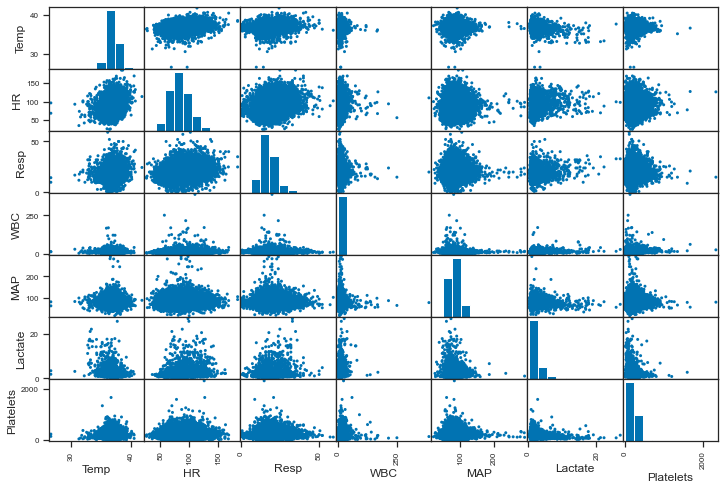

In [21]:
attributes = ["Temp", "HR", "Resp", "WBC", "MAP", "Lactate", "Platelets"]
scatter_matrix(X_train[attributes], figsize=(12,8))

# What should be kept for feature engineering?

Recommend:
drop columns with fewer  than 7k entries
    1. drop Bilirubin_direct
    1. drop EtCO2
    1. drop Fibrinogen
    1. drop Troponin I
    1. drop Lactate
    1. drop SaO2
    1. drop FiO2

median imputer for null values > 7k entries
    1.

scale columns > 7k entries
    1.

drop non-biological markers
    1. Age
    1. Gender
    1. Unit1
    1. Unit2
    1. HosAdmTime
    1. ICULOS
